# MNIST as Hamiltonians

In this notebook we study the MNIST dataset as an ensemble of Hamiltonians. In particular, we analyze how eigenvector ensembling fares on the task of classifying digits from images.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import eig
from scipy.stats import mode
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## Loading, and scaling data

In [2]:
### loading
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target
### scaling
X = X/255
print("Shape of images: ", X.shape)
print("Shapes of targets: ", y.shape)

Shape of images:  (70000, 784)
Shapes of targets:  (70000,)


## Splitting train/val/test sets

In [3]:
np.random.seed(666)
shuffle = np.random.permutation(len(X))
X = X[shuffle]
y = y[shuffle]
train_size, val_size = (0.8,0.1)
t = int(train_size*len(X)); v = int(val_size*len(X))
X_train = X[:t,:]; y_train = y[:t]
X_val = X[t:t+v,:]; y_val = y[t:t+v]
X_test = X[t+v:,:]; y_test = y[t+v:]
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=666)

## Visualizing some digits

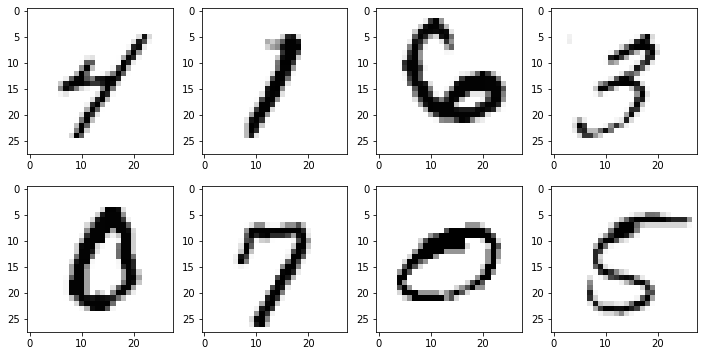

In [4]:
nrows=2
ncols=4
figsize=(12,6)
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
for i in range(nrows*ncols):
    axes[i//ncols,i%ncols].imshow(X_train[i,:].reshape((28,28)),cmap="Greys")

## Training a simple decision tree 

In [5]:
tree = DecisionTreeClassifier()

In [6]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [7]:
y_pred_train = tree.predict(X_train)
accuracy_score(y_train,y_pred_train)

1.0

In [8]:
y_pred_val = tree.predict(X_val)
accuracy_score(y_val,y_pred_val)

0.8741428571428571

## Training a random forest

Let us see if this improves with a random forest.

In [9]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1)
forest.fit(X_train,y_train)
y_pred_train = forest.predict(X_train)
accuracy_score(y_train,y_pred_train)

1.0

In [10]:
y_pred_val = forest.predict(X_val)
accuracy_score(y_val,y_pred_val)

0.9694285714285714

## Eigenvector ensembling

Let us now treat each image as a matrix and compute its eigenvectors

In [11]:
def compute_eigenvectors(X):
    mnist_eigenvectors = []
    for vector in tqdm(X):
        matrix = vector.reshape((28,28))
        eigenvectors = eig(matrix)[1].T
        real_part = np.real(eigenvectors)
        imaginary_part = np.imag(eigenvectors)
        real_concat_imaginary = np.concatenate((real_part, imaginary_part), axis=1)
        mnist_eigenvectors.append(real_concat_imaginary)
    return np.array(mnist_eigenvectors)

In [12]:
mnist_eigenvectors = compute_eigenvectors(X)

100%|██████████| 70000/70000 [00:06<00:00, 10270.88it/s]


Let us check our list of mnist eigenvectors. 

In [13]:
print("Shape of mnist_eigenvectors: ", mnist_eigenvectors.shape)

Shape of mnist_eigenvectors:  (70000, 28, 56)


In [14]:
def flatten_3d_matrix(eigenvector_dataset):
    shape = eigenvector_dataset.shape
    return np.reshape(eigenvector_dataset,(shape[0]*shape[1],-1))
    

In [15]:
### training eigenvector dataset
mnist_eigenvectors_train = compute_eigenvectors(X_train)
X_train_eigen = flatten_3d_matrix(mnist_eigenvectors_train)
y_train_eigen = np.repeat(y_train,28)
### validation eigenvector dataset
mnist_eigenvectors_val = compute_eigenvectors(X_val)
X_val_eigen = flatten_3d_matrix(mnist_eigenvectors_val)
y_val_eigen = np.repeat(y_val,28)

100%|██████████| 7000/7000 [00:00<00:00, 10647.93it/s]


### Eigenvector ensembling with decision trees

In [16]:
tree = DecisionTreeClassifier()
tree.fit(X_train_eigen,y_train_eigen)
y_pred_train_eigen = tree.predict(X_train_eigen)
accuracy_score(y_train_eigen,y_pred_train_eigen)

0.6269668367346939

### Eigenvector ensembling

In [18]:
y_ensembled = []
for i in range(0,len(X_train_eigen)//28):
    #print("i: ", i)
    arr = y_pred_train_eigen[i*28:(i+1)*28].astype(int)
    elected = mode(arr)[0]
    #print("elected: ", elected)
    #u, indices = np.unique(arr, return_inverse=True)
    #y_ensembled.append(u[np.argmax(np.bincount(indices))])
    y_ensembled.append(elected[0])
    #print("len: ", len(y_ensembled))

In [19]:
accuracy_score(y_train.astype(int),y_ensembled)

0.7309285714285715

#### Validation score

In [20]:
y_pred_val_eigen = tree.predict(X_val_eigen)
accuracy_score(y_val_eigen,y_pred_val_eigen)

0.31434693877551023

In [22]:
y_ensembled_val = []
for i in range(0,len(X_val_eigen)//28):
    #print("i: ", i)
    arr = y_pred_val_eigen[i*28:(i+1)*28].astype(int)
    elected = mode(arr)[0]
    #print("elected: ", elected)
    #u, indices = np.unique(arr, return_inverse=True)
    #y_ensembled.append(u[np.argmax(np.bincount(indices))])
    y_ensembled_val.append(elected[0])
    #print("len: ", len(y_ensembled_val))

In [23]:
accuracy_score(y_val.astype(int),y_ensembled_val)

0.25642857142857145

## Eigenvector ensembling with Random Forests

In [24]:
forest = RandomForestClassifier(n_estimators=100,n_jobs=-1)
forest.fit(X_train_eigen,y_train_eigen)
y_pred_train_eigen = forest.predict(X_train_eigen)
accuracy_score(y_train_eigen,y_pred_train_eigen)

0.6268947704081632

In [26]:
y_ensembled = []
for i in range(0,len(X_train_eigen)//28):
    #print("i: ", i)
    arr = y_pred_train_eigen[i*28:(i+1)*28].astype(int)
    elected = mode(arr)[0]
    #print("elected: ", elected)
    #u, indices = np.unique(arr, return_inverse=True)
    #y_ensembled.append(u[np.argmax(np.bincount(indices))])
    y_ensembled.append(elected[0])
    #print("len: ", len(y_ensembled))
accuracy_score(y_train.astype(int),y_ensembled)

0.7311785714285715

### Validation

In [27]:
y_pred_val_eigen = forest.predict(X_val_eigen)
accuracy_score(y_val_eigen,y_pred_val_eigen)

0.39706632653061225

In [29]:
y_ensembled_val = []
for i in range(0,len(X_val_eigen)//28):
    #print("i: ", i)
    arr = y_pred_val_eigen[i*28:(i+1)*28].astype(int)
    elected = mode(arr)[0]
    #print("elected: ", elected)
    #u, indices = np.unique(arr, return_inverse=True)
    #y_ensembled.append(u[np.argmax(np.bincount(indices))])
    y_ensembled_val.append(elected[0])
    #print("len: ", len(y_ensembled_val))

In [30]:
accuracy_score(y_val.astype(int),y_ensembled_val)

0.411

## Training on eigenvector images

### Generating targets for eigenvector dataset

In [19]:
y_train_eigen = np.repeat(y_train,28)


In [34]:
y_train[3]

'1'

In [35]:
y_train_eigen[84:112]

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1'], dtype=object)

In [66]:
mode([1,2,2,2])[0]

array([2])

In [61]:
help(mode)

Help on function mode in module scipy.stats.stats:

mode(a, axis=0, nan_policy='propagate')
    Return an array of the modal (most common) value in the passed array.
    
    If there is more than one such value, only the smallest is returned.
    The bin-count for the modal bins is also returned.
    
    Parameters
    ----------
    a : array_like
        n-dimensional array of which to find mode(s).
    axis : int or None, optional
        Axis along which to operate. Default is 0. If None, compute over
        the whole array `a`.
    nan_policy : {'propagate', 'raise', 'omit'}, optional
        Defines how to handle when input contains nan. 'propagate' returns nan,
        'raise' throws an error, 'omit' performs the calculations ignoring nan
        values. Default is 'propagate'.
    
    Returns
    -------
    mode : ndarray
        Array of modal values.
    count : ndarray
        Array of counts for each mode.
    
    Examples
    --------
    >>> a = np.array([[6, 8, 3, 

In [40]:
flattened.shape

(1960000, 56)

In [59]:
flattened[29]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [58]:
mnist_eigenvectors[1,1,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [34]:
np.linalg.norm(mnist_eigenvectors[0,:,:],axis=1a
        )

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [15]:
ar = np.array([[1+2j, 2+3j], [3+4j, 4+5j]])

In [16]:
ar

array([[1.+2.j, 2.+3.j],
       [3.+4.j, 4.+5.j]])

In [17]:
np.real(ar)

array([[1., 2.],
       [3., 4.]])

In [19]:
np.imag(ar)

array([[2., 3.],
       [4., 5.]])

In [5]:
X[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
mnist = fetch_mldata('MNIST original', data_home=custom_data_home)